In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [5]:
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32') 

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

# Weights and biases
w = torch.randn(2, 3, requires_grad=True)   # size of (2,3) matrix.
b = torch.randn(2, requires_grad=True)      # bias vector of size 2.

In [7]:
inputs.shape

torch.Size([5, 3])

In [8]:
inputs @ w.t() + b

tensor([[   9.1055,  -36.0599],
        [  15.7757,  -59.7734],
        [  30.9698, -108.9367],
        [ -12.9339,   26.3399],
        [  29.5279,  -97.2429]], grad_fn=<AddBackward0>)

In [9]:
def model(x):
    return x @ w.t() + b

In [10]:
preds = model(inputs)

In [17]:
mse = nn.MSELoss()
loss=mse(preds,targets)

In [19]:
loss.backward()

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [20]:
w.grad

tensor([[ -5130.0347,  -5846.6396,  -3546.4346],
        [-11885.8672, -14978.2588,  -8882.7656]])

In [ ]:
'''
with pytorch optimizer
'''

In [22]:
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32') 

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

In [23]:
model = nn.Linear(3, 2)

In [29]:
preds=model(inputs)
loss_fn = F.mse_loss
loss = loss_fn(model(inputs), targets)
opt = torch.optim.SGD(model.parameters(), lr=1e-5)
loss.backward()

In [31]:
opt.step()
opt.zero_grad()

In [ ]:
'''
solving our problem
no normalization
'''

In [2]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
import time
import models
from utils import logger, write_log
torch.backends.cudnn.benchmark=True
from glob import glob
import importlib
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from models import DFFNet
from dataloader import FoD500Loader

bs=6
f_dist=[0.1, 0.15, 0.3, 0.7, 1.5]
s_init=torch.rand((1,1,256,256),requires_grad=True)

database = '/scratch/lnw8px/depth-from-Focus-Defocus/defocus-net/data/fs_6/'
FoD500_train, FoD500_val = FoD500Loader(database, n_stack=5, scale=1)
FoD500_train, FoD500_val =  [FoD500_train], [FoD500_val]
dataset_train = torch.utils.data.ConcatDataset(FoD500_train)
dataset_val = torch.utils.data.ConcatDataset(FoD500_val)
TrainImgLoader = torch.utils.data.DataLoader(dataset=dataset_train, num_workers=4, batch_size=bs, shuffle=True, drop_last=True)
ValImgLoader = torch.utils.data.DataLoader(dataset=dataset_val, num_workers=1, batch_size=bs, shuffle=False, drop_last=True)

for batch_idx, (img_stack_in, disp,coc_stack,foc_dist) in enumerate(TrainImgLoader):
    break
img_stack_in=Variable(torch.FloatTensor(img_stack_in))
gt_disp=Variable(torch.FloatTensor(disp))
img_stack,gt_disp,foc_dist,blur_stack=img_stack_in,gt_disp,foc_dist,coc_stack

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
f_dist=torch.tensor([0.1, 0.15, 0.3, 0.7, 1.5])
min_f=torch.min(f_dist).unsqueeze(0).repeat_interleave(5,dim=0)
s=gt_disp[0,0,100,100].unsqueeze(0).repeat_interleave(5,dim=0)
N=1.0
f=2.9 * 1e-3
c=blur_stack[0,:,100,100]
c_norm=c/torch.max(c)
s,c_norm

In [14]:
f_dist=torch.tensor([0.1, 0.15, 0.3, 0.7, 1.5])
min_f=torch.min(f_dist).unsqueeze(0).repeat_interleave(5,dim=0)
s=torch.tensor([0.89]*5)
N=1.0
f=2.9 * 1e-3
f=torch.tensor([f]*5)
c=abs(s-f_dist)*f**2/(s*N*(f_dist-f))
c_norm=c/torch.max(c)
c_norm

tensor([1.0000, 0.6183, 0.2441, 0.0335, 0.0501])

In [21]:
s>f_dist

tensor([ True,  True,  True,  True, False])

In [19]:
(min_f*c_norm*(f_dist-f)-f_dist*(min_f-f))/(c_norm*(f_dist-f)+f-min_f)

tensor([   nan, 0.8900, 0.8900, 0.8900, 6.2444])

In [22]:
c_norm*(f_dist-f)+f-min_f

tensor([ 0.0000, -0.0061, -0.0246, -0.0737, -0.0221])

In [142]:
s_est=torch.tensor([0.1]*5,requires_grad=True)
min_f=torch.min(f_dist).unsqueeze(0).repeat_interleave(5,dim=0)
opt = torch.optim.SGD(params=[s_est] , lr = 1e-5)

In [38]:
c_est=(abs(s_est-f_dist)/(f_dist-f))/((s_est-min_f)/(min_f-f))
loss=F.mse_loss(c_est,c_norm,reduction='none').mean()
loss.backward()

In [1060]:
s_est.grad

In [150]:
s_list=[]
grads=[]
losses=[]
for i in range(100):
    opt.zero_grad()
    c_est=(abs(s_est-f_dist)/(f_dist-f))/((s_est-min_f)/(min_f-f))
    loss=F.mse_loss(c_est*100,c_norm*100,reduction='none').mean()
    print(loss)
    loss.backward()
    losses.append(loss.item())
    opt.step()
    
    with torch.no_grad():
        #s_est-=s_est.grad*1e-6
        grads.append(s_est.grad.mean().item())
        #s_est.grad.zero_()
    
    s_list.append(s_est.mean().item())

tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
t

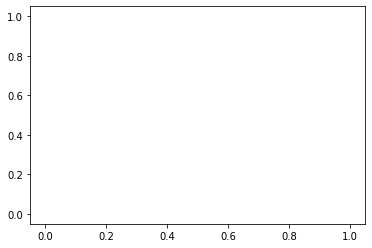

In [148]:
plt.plot(grads)

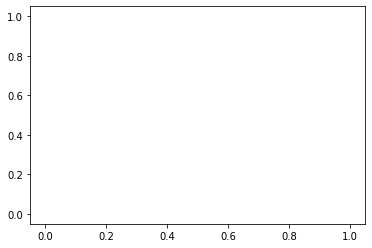

In [149]:
plt.plot(losses)

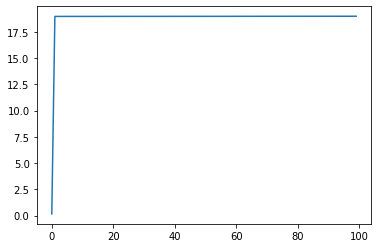

In [137]:
plt.plot(s_list)

In [87]:
s_est

tensor([0.4000, 0.8428, 0.8892, 0.8900, 0.8902], requires_grad=True)

In [974]:
s_est.grad

In [801]:
c_est=(abs(s-f_dist)/(f_dist-f))/((s-min_f)/(min_f-f))
c_est

tensor([1.0000, 0.6183, 0.2441, 0.0335, 0.0501])

In [827]:
3/0.01

300.0

In [804]:
for s_est in [0.6,0.7,0.8,0.89,0.9,1.2]:
    st=torch.tensor([s_est]*5)
    c_est=(abs(st-f_dist)/(f_dist-f))/((st-min_f)/(min_f-f))
    print("s="+str(s_est)+"blur=" +str(c_est))

s=0.6blur=tensor([1.0000, 0.5941, 0.1961, 0.0279, 0.1167])
s=0.7blur=tensor([1.0000, 0.6051, 0.2179, 0.0000, 0.0865])
s=0.8blur=tensor([1.0000, 0.6129, 0.2334, 0.0199, 0.0649])
s=0.89blur=tensor([1.0000, 0.6183, 0.2441, 0.0335, 0.0501])
s=0.9blur=tensor([1.0000, 0.6188, 0.2451, 0.0348, 0.0486])
s=1.2blur=tensor([1.0000, 0.6301, 0.2674, 0.0633, 0.0177])


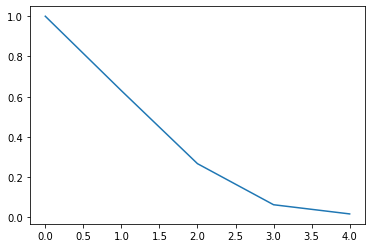

In [828]:
plt.plot(c_est)

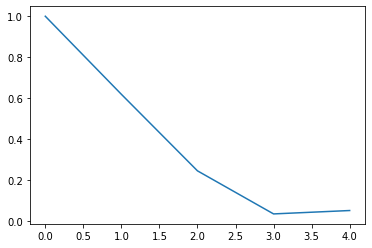

In [829]:
plt.plot(c_norm)

In [464]:
class Blur(torch.nn.Module):

    def __init__(self,s_init,f_dist,f,N):
        super(Blur, self).__init__()
        self.s=nn.Parameter(s_init)
        self.f_dist=f_dist
        self.N=N
        self.f=f

    def forward(self):
        b=abs(self.s-self.f_dist)*self.f**2/(self.s*self.N*(self.f_dist-self.f))
        return b

In [807]:
class Blur(torch.nn.Module):

    def __init__(self,s_init,f_dist,f,N):
        super(Blur, self).__init__()
        self.s=nn.Parameter(s_init)
        self.f_dist=f_dist
        self.N=N
        self.f=f
        self.min_f=torch.min(f_dist).unsqueeze(0).repeat_interleave(5,dim=0)

    def forward(self):
        b=(abs(self.s-self.f_dist)/(self.f_dist-self.f))/((self.s-self.min_f)/(self.min_f-self.f))
        return b

In [823]:
s=torch.tensor([0.9]*5,requires_grad=True)
model=Blur(s,f_dist,f,N)
opt = torch.optim.SGD(model.parameters(), lr=1e-6)

In [824]:
loss_list=[]
s_list=[]
for i in range(1000):
    blur_pred=model()
    loss=F.mse_loss(c,blur_pred,reduction='none').mean()
    loss_list.append(loss.item())
    s_list.append(s.mean().item())
    loss.backward()
    opt.step()

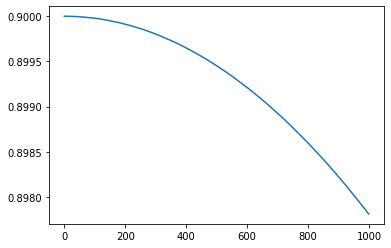

In [825]:
plt.plot(s_list)

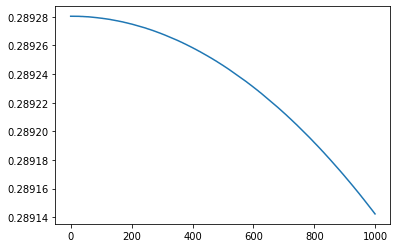

In [826]:
plt.plot(loss_list)

In [546]:
torch.min(f_dist).unsqueeze(0).shape

torch.Size([1])

In [531]:
blur_pred=model()
loss=F.mse_loss(c,blur_pred,reduction='none').mean()*1e6
print(loss)
print(list(model.parameters())[0])
loss.backward()
opt.step()

tensor(1704.9534, grad_fn=<MulBackward0>)
Parameter containing:
tensor([  4.9795,   3.8276,   2.3319,  -5.0458, -40.5595], requires_grad=True)


Parameter containing:
tensor([0.6000, 0.6000, 0.6000, 0.6000, 0.6000], requires_grad=True)

In [114]:
blur_pred=model()
loss=F.mse_loss(c,blur_pred,reduction='none').mean()
print(loss)
loss.backward()
opt.step()

tensor(1.9214e-11, grad_fn=<MeanBackward0>)


In [118]:
list(blur.parameters())[0]

Parameter containing:
tensor([0.6000, 0.6000, 0.6000, 0.6000, 0.6000], requires_grad=True)

In [86]:
gt_disp[0,0,0,0]

tensor(0.4585)

In [77]:
torch.min(gt_disp),torch.max(gt_disp)

(tensor(0.1000), tensor(2.8398))

In [ ]:
blur_pred=blur()
loss=F.mse_loss(coc_stack_norm,blur_pred,reduction='none').mean()
dst_er=F.mse_loss(disp.cuda(),list(blur.parameters())[0].data[:,0,:,:].cuda(),reduction='none').mean()
print('blur_loss='+str(loss.item())+' dist loss='+str(dst_er.item()))
#print(list(blur.parameters())[0].data.mean())
loss.backward()
opt.step()

In [ ]:
'''
solving our problem
'''

In [70]:
s2=3
n_s1=6
s1=torch.from_numpy(np.linspace(0.1,1.5,n_s1))
f=2.9 * 1e-3
c=abs(s2-s1)*(min(s1)-f)/((s1-f)*(s2-min(s1)))

In [42]:
s=nn.Linear(1, 1)
abs(s-s1)*(min(s1)-f)/((s1-f)*(s-min(s1)))

TypeError: unsupported operand type(s) for -: 'Linear' and 'float'

In [73]:
s=torch.tensor([2.0]*n_s1,requires_grad=True)
def model(x):
    s=nn.Linear(1, 1)
    return abs(x-s1)*(min(s1)-f)/((s1-f)*(x-min(s1)))

In [281]:
class Blur(torch.nn.Module):

    def __init__(self,s_init,f_dist,f,bs):
        super(Blur, self).__init__()
        f_dist=torch.tensor(f_dist)
        
        s1=f_dist.unsqueeze(0).unsqueeze(2).unsqueeze(3)
        self.s1=s1.repeat_interleave(6,dim=0).repeat_interleave(256,dim=2).repeat_interleave(256,dim=3)

        min_s1=torch.min(f_dist)
        min_s1=min_s1.unsqueeze(0).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        self.min_s1=min_s1.repeat_interleave(6,dim=0).repeat_interleave(5,dim=1).repeat_interleave(256,dim=2).repeat_interleave(256,dim=3)
        
        self.s=s_init.repeat_interleave(bs,dim=0).repeat_interleave(len(f_dist),dim=1)
        
        self.f=torch.full((bs,len(f_dist),256,256),f,dtype=torch.float64)

    def forward(self):
        blur=abs(self.s-self.s1)*(self.min_s1-self.f)/((self.s1-self.f)*(self.s-self.min_s1))
        return blur
    def get_s(self):
        return self.s

In [242]:
bs=6
f_dist=[0.1, 0.15, 0.3, 0.7, 1.5]
s=torch.empty((1,1,256,256),requires_grad=True).repeat_interleave(bs,dim=0).repeat_interleave(len(f_dist),dim=1)
s.shape

torch.Size([6, 5, 256, 256])

In [282]:
bs=6
f_dist=[0.1, 0.15, 0.3, 0.7, 1.5]
s_init=torch.rand((1,1,256,256),requires_grad=True)

blur=Blur(s_init,f_dist,2.9*1e-3,bs)
blur().shape

torch.Size([6, 5, 256, 256])

In [290]:
blur.get_s().grad

/opt/conda/lib/python3.7/site-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "


In [263]:
s_init.repeat_interleave(bs,dim=0).repeat_interleave(len(f_dist),dim=1).shape

torch.Size([6, 5, 256, 256])

In [237]:
blur=Blur(2,[0.1, 0.15, 0.3, 0.7, 1.5],2.9*1e-3,6)
blur().shape

torch.Size([6, 5, 256, 256])
torch.Size([6, 5, 256, 256])


torch.Size([6, 5, 256, 256])

In [223]:
s1=[0.1, 0.15, 0.3, 0.7, 1.5]
torch.min(s1)

TypeError: min(): argument 'input' (position 1) must be Tensor, not list

In [222]:
s1=[0.1, 0.15, 0.3, 0.7, 1.5]
s1=torch.tensor(s1)
s1=s1.unsqueeze(0).unsqueeze(2).unsqueeze(3)
s1=s1.repeat_interleave(6,dim=0).repeat_interleave(256,dim=2).repeat_interleave(256,dim=3)
s1.shape

torch.Size([6, 5, 256, 256])

In [215]:
s1=[0.1, 0.15, 0.3, 0.7, 1.5]
s1=torch.tensor(s1)
min_s1=torch.min(s1)
min_s1=min_s1.unsqueeze(0).unsqueeze(1).unsqueeze(2).unsqueeze(3)
min_s1.repeat_interleave(6,dim=0).repeat_interleave(5,dim=1).repeat_interleave(256,dim=2).repeat_interleave(256,dim=3)

torch.Size([6, 5, 256, 256])

In [200]:
blur=Blur(2,5,2.9*1e-3,6)
blur().shape

In [201]:
blur().shape

torch.Size([6, 5, 256, 256])
torch.Size([30, 256, 256, 1])


RuntimeError: The size of tensor a (5) must match the size of tensor b (256) at non-singleton dimension 1

In [173]:
f=2.9*1e-3
torch.full((5,256,256),f,dtype=torch.float64)

tensor([[[0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         ...,
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029]],

        [[0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         ...,
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029]],

        [[0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.

In [139]:
s1=torch.from_numpy(np.linspace(0.1,1.5,5))
s1=torch.unsqueeze(s1,1).unsqueeze(2)
s1=torch.repeat_interleave(s1,256,dim=1).repeat_interleave(256,dim=2)
s1.shape

torch.Size([5, 256, 256])

In [166]:
torch.from_numpy(np.linspace(0.1,1.5,5))

torch.Size([5])

In [164]:
min_s1=torch.min(s1,dim=0,keepdim=True).values
min_s1=torch.repeat_interleave(min_s1,5,dim=0)
min_s1.shape

torch.Size([5, 256, 256])

In [90]:
e=torch.empty((1,256,256),requires_grad=True)
e.shape

torch.Size([1, 256, 256])

In [96]:
e = torch.empty((1,256,256),requires_grad=True)
s=torch.repeat_interleave(e, 3, dim=0)
nn.init.constant_(s, 3)

tensor([[[3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         ...,
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.]],

        [[3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         ...,
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.]],

        [[3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         ...,
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.]]], grad_fn=<IndexSelectBackward>)

In [74]:
loss_fn = F.mse_loss
loss = loss_fn(model(s), c)
opt = torch.optim.SGD(model.parameters(), lr=1e-5)
loss.backward()

AttributeError: 'function' object has no attribute 'parameters'

In [ ]:
'''
With real data from FOD
'''

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
import time
import models
from utils import logger, write_log
torch.backends.cudnn.benchmark=True
from glob import glob
import importlib
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from models import DFFNet
from dataloader import FoD500Loader

In [153]:
class Blur(torch.nn.Module):

    def __init__(self,s_init,f_dist,f,bs):
        super(Blur, self).__init__()
        f_dist=torch.tensor(f_dist)
        
        s1=f_dist.unsqueeze(0).unsqueeze(2).unsqueeze(3)
        self.s1=s1.repeat_interleave(6,dim=0).repeat_interleave(224,dim=2).repeat_interleave(224,dim=3)

        min_s1=torch.min(f_dist)
        min_s1=min_s1.unsqueeze(0).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        self.min_s1=min_s1.repeat_interleave(6,dim=0).repeat_interleave(5,dim=1).repeat_interleave(224,dim=2).repeat_interleave(224,dim=3)
        
        s=s_init.repeat_interleave(bs,dim=0).repeat_interleave(len(f_dist),dim=1)
        self.s=nn.Parameter(s)
        
        self.f=torch.full((bs,len(f_dist),224,224),f,dtype=torch.float64).cuda()

    def forward(self):
        #blur=abs(self.s-self.s1) + self.f.cuda()
        blur=abs(self.s-self.s1)*(self.min_s1-self.f)/((self.s1-self.f)*(self.s-self.min_s1))
        return blur
    def get_s(self):
        return self.s

In [241]:
bs=6
f_dist=torch.tensor([0.1, 0.15, 0.3, 0.7, 1.5]).cuda()
s_init=torch.rand((1,1,224,224),requires_grad=True).cuda()
f=torch.tensor(2.9*1e-3).cuda()
blur=Blur(s_init,f_dist,f,bs)
blur=blur.cuda()
opt = torch.optim.SGD(blur.parameters(), lr=1e-5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [218]:
coc_stack_norm.shape,s_init.shape

(torch.Size([6, 5, 224, 224]), torch.Size([1, 1, 224, 224]))

In [109]:
database = '/scratch/lnw8px/depth-from-Focus-Defocus/defocus-net/data/fs_6/'
FoD500_train, FoD500_val = FoD500Loader(database, n_stack=5, scale=1)
FoD500_train, FoD500_val =  [FoD500_train], [FoD500_val]
dataset_train = torch.utils.data.ConcatDataset(FoD500_train)
dataset_val = torch.utils.data.ConcatDataset(FoD500_val)
TrainImgLoader = torch.utils.data.DataLoader(dataset=dataset_train, num_workers=4, batch_size=bs, shuffle=True, drop_last=True)
ValImgLoader = torch.utils.data.DataLoader(dataset=dataset_val, num_workers=1, batch_size=bs, shuffle=False, drop_last=True)

for batch_idx, (img_stack_in, disp,coc_stack,foc_dist) in enumerate(TrainImgLoader):
    break
img_stack_in=Variable(torch.FloatTensor(img_stack_in))
gt_disp=Variable(torch.FloatTensor(disp))
img_stack,gt_disp,foc_dist,coc_stack=img_stack_in.cuda(),gt_disp.cuda(),foc_dist.cuda(),coc_stack.cuda()

coc_mean=torch.mean(coc_stack,dim=1)
coc_mean=torch.unsqueeze(coc_mean,dim=1)

coc_max=torch.max(coc_stack,dim=1).values
coc_max=torch.unsqueeze(coc_max,dim=1)

coc_min=torch.min(coc_stack,dim=1).values
coc_min=torch.unsqueeze(coc_min,dim=1)

coc_max=torch.repeat_interleave(coc_max,repeats=5,dim=1)
coc_min=torch.repeat_interleave(coc_min,repeats=5,dim=1)

coc_stack_norm=(coc_stack-coc_min)/(coc_max-coc_mean)

In [221]:
disp.shape,list(blur.parameters())[0].data.shape

(torch.Size([6, 1, 224, 224]), torch.Size([6, 5, 224, 224]))

In [224]:
list(blur.parameters())[0].data[0,2,:,:]

tensor([[0.7088, 0.7852, 0.5476,  ..., 0.8435, 0.6984, 0.2869],
        [0.2289, 0.0520, 0.6120,  ..., 0.9177, 0.4395, 0.5060],
        [0.2784, 0.6312, 0.6926,  ..., 0.4459, 0.0649, 0.9821],
        ...,
        [0.5888, 0.8785, 0.8052,  ..., 0.9915, 0.7675, 0.0311],
        [0.1962, 0.6144, 0.7611,  ..., 0.5275, 0.8398, 0.9922],
        [0.1701, 0.9617, 0.2371,  ..., 0.2261, 0.6807, 0.5573]],
       device='cuda:0')

In [228]:
F.mse_loss(disp.cuda(),list(blur.parameters())[0].data[:,0,:,:].cuda(),reduction='none').mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Using a target size (torch.Size([6, 224, 224])) that is different to the input size (torch.Size([6, 1, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  """Entry point for launching an IPython kernel.


tensor(0.1712, device='cuda:0')

In [239]:
loss.item()

3.197618029031643

In [242]:
for i in range(20):
    blur_pred=blur()
    loss=F.mse_loss(coc_stack_norm,blur_pred,reduction='none').mean()
    dst_er=F.mse_loss(disp.cuda(),list(blur.parameters())[0].data[:,0,:,:].cuda(),reduction='none').mean()
    print('blur_loss='+str(loss.item())+' dist loss='+str(dst_er.item()))
    #print(list(blur.parameters())[0].data.mean())
    loss.backward()
    opt.step()

    #list(blur.parameters())[0].data.mean()

blur_loss=1758331.9976143532 dist loss=0.1713479459285736
blur_loss=12.470370135837051 dist loss=0.1713479459285736
blur_loss=10.415849174528507 dist loss=0.1713479459285736
blur_loss=9.272399733909799 dist loss=0.1713479459285736
blur_loss=8.490850544355139 dist loss=0.1713479459285736
blur_loss=7.905070798707255 dist loss=0.1713479459285736
blur_loss=7.441756339544754 dist loss=0.1713479459285736
blur_loss=7.06200295591677 dist loss=0.1713479459285736
blur_loss=6.742704793871608 dist loss=0.1713479459285736
blur_loss=6.469037611045301 dist loss=0.1713479459285736
blur_loss=6.230930978921432 dist loss=0.1713479459285736
blur_loss=6.021236822229834 dist loss=0.1713479459285736
blur_loss=5.834699332918551 dist loss=0.1713479459285736
blur_loss=5.667344402253246 dist loss=0.1713479459285736
blur_loss=5.516095985707164 dist loss=0.1713479459285736
blur_loss=5.378527872297812 dist loss=0.1713479459285736
blur_loss=5.252695574330215 dist loss=0.1713479459285736
blur_loss=5.137018984543228 d

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Using a target size (torch.Size([6, 224, 224])) that is different to the input size (torch.Size([6, 1, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  after removing the cwd from sys.path.


In [21]:
coc_stack_norm.shape, blur_pred.shape

(torch.Size([6, 5, 224, 224]), torch.Size([6, 5, 256, 256]))

In [209]:
coc_stack_norm

tensor([[[[1.7841, 1.7828, 1.7836,  ..., 1.5783, 1.5762, 1.5746],
          [1.7836, 1.7825, 1.7822,  ..., 1.5746, 1.5733, 1.5721],
          [1.7822, 1.7820, 1.7819,  ..., 1.5721, 1.5697, 1.5682],
          ...,
          [1.4887, 1.4896, 1.4920,  ..., 1.5242, 1.5205, 1.5177],
          [1.4888, 1.4908, 1.4927,  ..., 1.5171, 1.5140, 1.5105],
          [1.4896, 1.4920, 1.4929,  ..., 1.5109, 1.5067, 1.5043]],

         [[0.6820, 0.6835, 0.6860,  ..., 0.7819, 0.7800, 0.7800],
          [0.6860, 0.6861, 0.6887,  ..., 0.7800, 0.7786, 0.7780],
          [0.6887, 0.6900, 0.6936,  ..., 0.7780, 0.7759, 0.7752],
          ...,
          [0.7563, 0.7574, 0.7624,  ..., 0.8175, 0.8107, 0.8067],
          [0.7556, 0.7603, 0.7642,  ..., 0.8049, 0.7999, 0.7939],
          [0.7574, 0.7624, 0.7635,  ..., 0.7956, 0.7870, 0.7822]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0